In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Data Preprocessing

Loading and merging the datasets together:

In [2]:
categorical_train = pd.read_excel("files/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx")
functional_train = pd.read_csv("files/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv")
quantitative_train = pd.read_excel("files/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx")
solution_train = pd.read_excel("files/TRAIN/TRAINING_SOLUTIONS.xlsx")

In [28]:
df1 = pd.merge(categorical_train, functional_train)
df2 = pd.merge(quantitative_train, solution_train)
df = pd.merge(df1, df2)
df

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,...,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,2016,1,0.0,0,1,21,45,21,45,...,1,5,0,5,1,0,10,NaN,1,1
1,CPaeQkhcjg7d,2019,3,1.0,2,3,15,15,0,0,...,6,8,7,8,10,4,5,NaN,1,0
2,Nb4EetVPm3gs,2016,1,1.0,8,1,18,40,0,0,...,2,8,5,7,6,4,9,8.239904,1,0
3,p4vPhVu91o4b,2018,3,0.0,8,3,15,30,18,0,...,4,16,9,10,8,4,6,NaN,1,1
4,M09PXs7arQ5E,2019,3,0.0,1,3,15,20,0,0,...,4,11,4,10,7,3,9,8.940679,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,Atx7oub96GXS,2019,1,0.0,0,2,21,40,21,40,...,2,7,3,6,2,0,9,10.697923,0,0
1209,groSbUfkQngM,2016,1,0.0,0,1,18,35,0,0,...,3,11,9,5,7,4,7,13.964750,0,1
1210,zmxGvIrOD0bt,2015,1,1.0,2,1,18,20,0,0,...,1,3,0,0,1,0,10,NaN,0,1
1211,rOmWFuJCud5G,2018,3,0.0,8,3,21,40,18,45,...,0,9,3,5,0,0,9,12.089094,0,0


Feature engineering: dropping irrelevant columns and winsorizing

In [29]:
df = df.drop(columns=['participant_id', 'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ', 'EHQ_EHQ_Total', 'ColorVision_CV_Score',
       'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
       'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Prosocial',
       'MRI_Track_Age_at_Scan', 'Sex_F'])
df

,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,0throw_10thcolumn,...,198throw_199thcolumn,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,ADHD_Outcome
0,-0.039820,0.177577,0.057224,0.037571,0.118154,0.050951,0.090341,0.023182,-0.022061,-0.119067,...,-0.004984,0,6,1,5,0,5,1,0,1
1,0.114480,0.205675,0.079730,0.010349,0.015880,0.111704,0.061521,0.003817,-0.046700,-0.067740,...,0.194381,0,18,6,8,7,8,10,4,1
2,0.226402,0.159739,0.113252,0.077601,0.068376,0.105201,0.074643,0.016741,-0.024794,-0.014037,...,0.035150,1,14,2,8,5,7,6,4,1
3,0.060679,0.047981,0.058570,-0.019773,0.011671,0.128109,0.151120,-0.045360,0.006680,0.000595,...,0.234708,6,24,4,16,9,10,8,4,1
4,0.056123,0.178890,0.024387,0.001484,0.090777,0.102894,0.068803,-0.013159,0.084648,0.004003,...,0.143666,1,18,4,11,4,10,7,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,0.069553,0.128192,0.177524,-0.032054,0.101395,0.054353,-0.003717,-0.032183,0.046682,0.047385,...,0.149812,1,9,2,7,3,6,2,0,0
1209,0.028529,0.084814,0.052402,0.072345,0.112863,0.055816,0.013611,0.060787,0.046778,0.015596,...,0.135419,6,18,3,11,9,5,7,4,0
1210,0.024710,0.096665,0.053072,0.044169,0.127491,0.023128,0.133070,-0.006838,-0.014219,-0.046600,...,0.117584,3,4,1,3,0,0,1,0,0
1211,0.000999,0.139240,0.118345,0.063470,0.063035,0.092719,0.096701,-0.071364,0.023560,0.024507,...,0.117870,4,9,0,9,3,5,0,0,0


In [5]:
def winsorize_df(df, features, limits):
    for f in features:
        df[f] = stats.mstats.winsorize(df[f], limits=limits)

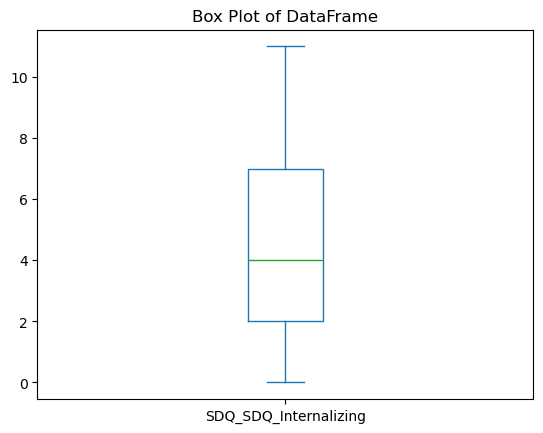

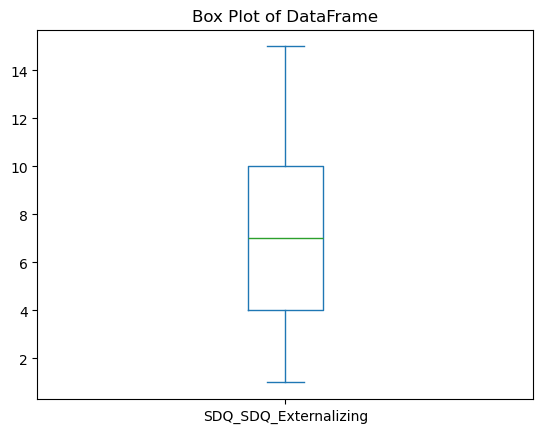

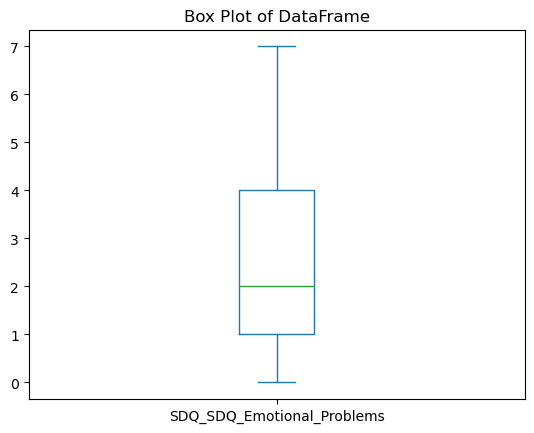

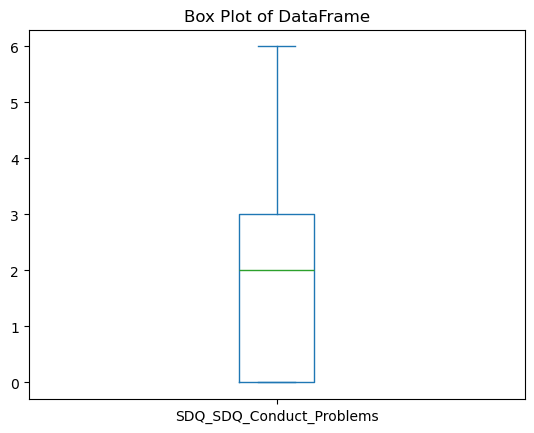

In [30]:
winsor_features = ['SDQ_SDQ_Internalizing', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Conduct_Problems']

for f in winsor_features:
    df[f] = stats.mstats.winsorize(df[f], limits=[0.05, 0.05])
    df[f].plot.box()
    plt.title('Box Plot of DataFrame')
    plt.show()

In [7]:
df.dtypes

0throw_1thcolumn         float64
0throw_2thcolumn         float64
0throw_3thcolumn         float64
0throw_4thcolumn         float64
0throw_5thcolumn         float64
                          ...   
SDQ_SDQ_Hyperactivity      int64
SDQ_SDQ_Internalizing      int64
SDQ_SDQ_Peer_Problems      int64
ADHD_Outcome               int64
Sex_F                      int64
Length: 19910, dtype: object

# Create Model

Creating a logistic regression model to predict ADHD outcomes and testing hyperparameters:

In [31]:
X_train = df.drop(columns=['ADHD_Outcome'])
y_train = df['ADHD_Outcome']

In [15]:
model = LogisticRegression(random_state=42)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga']
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

c:\Users\tiffa\miniconda3\envs\WIDS\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\tiffa\miniconda3\envs\WIDS\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\tiffa\miniconda3\envs\WIDS\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\tiffa\miniconda3\envs\WIDS\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\tiffa\miniconda3\envs\WIDS\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\tiffa\miniconda3\envs\WIDS\Lib\site-packages\s

KeyboardInterrupt: 

In [45]:
print('best_params: ', best_params)
print('best_score: ', best_score)

best_params:  {'C': 0.01, 'solver': 'lbfgs'}
best_score:  0.8029520797197565


In [32]:
final_model = LogisticRegression(C=0.01)
final_model.fit(X_train, y_train)

LogisticRegression(C=0.01)

# Testing Model

In [38]:
categorical_test = pd.read_excel("files/TEST/TEST_CATEGORICAL.xlsx")
functional_test = pd.read_csv("files/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
quantitative_test = pd.read_excel("files/TEST/TEST_QUANTITATIVE_METADATA.xlsx")

test_df1 = pd.merge(categorical_test, functional_test)
X_test = pd.merge(test_df1, quantitative_test)
X_test

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,Cfwaf5FX7jWK,2022,4,0.0,0.0,4,21.0,30.0,18.0,30.0,...,2.0,12.0,3.0,9.0,2.0,7.0,3.0,0.0,8.0,8.992813
1,vhGrzmvA3Hjq,2023,4,0.0,0.0,4,21.0,45.0,NaN,30.0,...,2.0,16.0,8.0,5.0,7.0,3.0,11.0,3.0,9.0,12.324093
2,ULliyEXjy4OV,2022,4,0.0,0.0,4,21.0,40.0,18.0,40.0,...,1.0,7.0,1.0,6.0,1.0,5.0,1.0,0.0,9.0,7.770933
3,LZfeAb1xMtql,2022,4,0.0,0.0,3,21.0,45.0,21.0,45.0,...,4.0,15.0,4.0,10.0,8.0,6.0,5.0,1.0,6.0,9.304814
4,EnFOUv0YK1RG,2022,4,2.0,0.0,4,18.0,0.0,21.0,45.0,...,2.0,18.0,6.0,12.0,5.0,10.0,6.0,0.0,10.0,8.261350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,UadZfjdEg7eG,2023,4,0.0,0.0,4,18.0,0.0,18.0,35.0,...,1.0,18.0,7.0,7.0,5.0,6.0,11.0,4.0,7.0,7.546999
300,IUEHiLmQAqCi,2023,4,0.0,1.0,3,18.0,35.0,21.0,40.0,...,2.0,16.0,2.0,11.0,5.0,9.0,5.0,3.0,8.0,10.531143
301,cRySmCadYFRO,2023,4,0.0,8.0,4,21.0,25.0,15.0,NaN,...,1.0,11.0,4.0,4.0,4.0,3.0,7.0,3.0,10.0,7.210586
302,E3MvDUtJadc5,2022,4,0.0,8.0,4,21.0,0.0,21.0,45.0,...,5.0,21.0,2.0,10.0,6.0,5.0,11.0,9.0,0.0,12.212183


In [39]:
X_test.isna().sum()

participant_id                       0
Basic_Demos_Enroll_Year              0
Basic_Demos_Study_Site               0
PreInt_Demos_Fam_Child_Ethnicity     3
PreInt_Demos_Fam_Child_Race          6
                                    ..
SDQ_SDQ_Hyperactivity               30
SDQ_SDQ_Internalizing               30
SDQ_SDQ_Peer_Problems               30
SDQ_SDQ_Prosocial                   30
MRI_Track_Age_at_Scan                0
Length: 19928, dtype: int64

In [42]:
# fill null values with mean
for col in X_test.columns:
    if X_test[col].isna().sum() > 0:
        X_test[col].fillna(X_test[col].mean(),inplace=True)

C:\Users\tiffa\AppData\Local\Temp\ipykernel_39048\3745341560.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test[col].fillna(X_test[col].mean(),inplace=True)


In [43]:
X_test.isna().sum()

participant_id                      0
Basic_Demos_Enroll_Year             0
Basic_Demos_Study_Site              0
PreInt_Demos_Fam_Child_Ethnicity    0
PreInt_Demos_Fam_Child_Race         0
                                   ..
SDQ_SDQ_Hyperactivity               0
SDQ_SDQ_Internalizing               0
SDQ_SDQ_Peer_Problems               0
SDQ_SDQ_Prosocial                   0
MRI_Track_Age_at_Scan               0
Length: 19928, dtype: int64

In [44]:
test_ids = X_test['participant_id']

# preprocess test dataset
winsorize_df(X_test, features=winsor_features, limits=[0.05,0.05])
X_test = X_test.drop(columns=['participant_id', 'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ', 'EHQ_EHQ_Total', 'ColorVision_CV_Score',
       'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
       'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Prosocial',
       'MRI_Track_Age_at_Scan'])
X_test

,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,0throw_10thcolumn,...,197throw_199thcolumn,198throw_199thcolumn,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems
0,0.548480,0.713607,0.557319,0.524369,0.693364,0.770032,0.724406,0.390118,0.547912,0.470220,...,0.560565,0.555732,2.0,12.0,3.0,9.0,2.0,7.0,3.0,0.0
1,0.427740,0.363022,0.402862,0.363003,0.534558,0.345347,0.409471,0.303328,0.402515,0.275052,...,0.559632,0.350027,2.0,16.0,6.0,5.0,7.0,3.0,11.0,3.0
2,0.139572,0.390106,-0.087041,0.196852,0.088148,0.023843,0.381782,0.068979,0.377488,0.301871,...,0.609856,0.750987,1.0,7.0,1.0,6.0,1.0,5.0,1.0,0.0
3,0.133561,0.778326,0.416355,0.471840,0.568460,0.633660,0.501113,0.345461,0.467943,0.417308,...,0.683189,0.542296,4.0,15.0,4.0,10.0,8.0,6.0,5.0,1.0
4,0.126699,0.575446,0.509422,0.363193,0.427544,0.449924,0.451796,0.223927,0.298248,0.304429,...,0.148529,0.539823,2.0,18.0,6.0,12.0,5.0,10.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,0.029721,0.596742,0.361898,0.292066,0.553130,0.476284,0.543970,0.372932,0.595183,0.265432,...,0.490833,0.568742,1.0,18.0,6.0,7.0,5.0,6.0,11.0,4.0
300,0.025985,0.347840,0.304804,0.463090,0.305321,0.267397,0.468712,0.155677,0.298155,0.049262,...,0.318518,0.305596,2.0,16.0,2.0,11.0,5.0,9.0,5.0,3.0
301,0.105385,0.443624,-0.019777,0.435582,0.376492,0.619322,0.430177,0.567600,0.399820,0.371101,...,0.680979,0.678973,1.0,11.0,4.0,4.0,4.0,3.0,7.0,3.0
302,0.345641,0.758986,0.748153,0.442141,0.571924,0.485011,0.530513,0.137672,0.467144,0.172004,...,0.429694,0.530238,5.0,21.0,2.0,10.0,6.0,5.0,11.0,9.0


In [60]:
predictions = pd.DataFrame({'ADHD_Outcome': final_model.predict(X_test)})
adhd_predictions = pd.concat([test_ids, predictions], axis=1)
adhd_predictions

,participant_id,ADHD_Outcome
0,Cfwaf5FX7jWK,1
1,vhGrzmvA3Hjq,1
2,ULliyEXjy4OV,1
3,LZfeAb1xMtql,1
4,EnFOUv0YK1RG,1
...,...,...
299,UadZfjdEg7eG,1
300,IUEHiLmQAqCi,1
301,cRySmCadYFRO,0
302,E3MvDUtJadc5,1


In [64]:
submission_df = pd.read_csv('submission.csv')
submission_df2 = pd.merge(adhd_predictions, submission_df)
submission_df2

,participant_id,ADHD_Outcome,Sex_F
0,Cfwaf5FX7jWK,1,0
1,vhGrzmvA3Hjq,1,1
2,ULliyEXjy4OV,1,0
3,LZfeAb1xMtql,1,0
4,EnFOUv0YK1RG,1,1
...,...,...,...
299,UadZfjdEg7eG,1,1
300,IUEHiLmQAqCi,1,0
301,cRySmCadYFRO,0,1
302,E3MvDUtJadc5,1,0


In [65]:
submission_df2.to_csv('submission.csv', index=False)